**Background**
1. https://www.pnas.org/doi/10.1073/pnas.1520760112 (original article)
2. Kaggle Page: https://www.kaggle.com/datasets/usharengaraju/crimeagainstwomen/data

3. NCBI GEO: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi

In [1]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %code_wrap  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %mamba  %man  %matplotlib  %micromamba  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%code_wrap  %%debug  %%file  %%html  %%javascript  %%js  %

**Necessary for Scanpy Installation**

In [2]:
import scanpy              as sc
import pandas              as pd
import numpy               as np
import gseapy              as gp
import seaborn             as sns

import matplotlib.pyplot   as plt
from   PIL                 import Image
from   zipfile             import ZipFile
from scipy.stats           import median_abs_deviation

import re
import os
import igraph

from sklearn.decomposition import PCA

**Upload Data Extracked from RDS Data Object**

In [3]:
def load_data():
  '''
  Load the extracted rds files from R

  Parameters:
    None

  Returns:
    meta_data: gene and cell type metadata
    genes: gene symbols
    expression_data: log2 transformed gene expression_data for scRNA

  '''
  meta_data       = pd.read_csv('col_data.csv', index_col = 0)
  genes           = pd.read_csv('row_data.csv')
  genes           = genes.drop(columns = genes.columns[0])
  expression_data = pd.read_csv('logcounts.csv', index_col = 0)
  expression_data = expression_data.map(lambda x: (2**x) -1 )
  # expression_data = pd.read_csv('GSE75140_hOrg.fetal.master.data.frame.txt', sep = '\t', index_col = 0)
  return meta_data, genes, expression_data

meta_data, genes, expression_data = load_data()

In [4]:
def pull_mitochondrial_genes():
  GO_terms            = gp.read_gmt('GO_Cellular_Component_2023.gmt')
  mitochondrial_genes = []
  for component in GO_terms:
    if 'mitochondria' in str(component).lower():
      genes   = GO_terms[component]
      mitochondrial_genes.extend(genes)

  mitochondrial_genes = pd.Series(mitochondrial_genes)
  mitochondrial_genes = mitochondrial_genes.unique()

  return mitochondrial_genes

mitochondrial_genes      = pull_mitochondrial_genes()

In [5]:
mitochondrial_expression = expression_data.loc[[gene for gene in mitochondrial_genes if gene in expression_data.index]]

**Relabel Mitochondrial Genes For Quality Checks Later**
1. High level of Mitochondrial genes indicates ruptured membranes

In [6]:
def label_mitochondrial(expression_data, mitochondrial_genes):
  '''
  Function using GO Cellular Components to identify and label mitochondrial genes

  Parameters:
    expression_data: Original expression data loaded from Kaggle
    mitochondrial_genes: Genes in GO Cellular Components that GO term with "mitochondrial"

  Returns:
    expression_data: Relabeled index with MT_ prefix


  '''
  relabeled_index = []
  for index in expression_data.index:
    if index in mitochondrial_genes:
      gene = 'MT_' + index
      relabeled_index.append(gene)

    else:
      relabeled_index.append(index)

  expression_data.index = relabeled_index

  return expression_data

expression_data = label_mitochondrial(expression_data, mitochondrial_genes)

# Metadata EDA

In [7]:
meta_data['batch'].unique()

array(['fetal human cortex 1', 'fetal human cortex 2', 'ESC H9',
       'iPSC 409B2'], dtype=object)

In [8]:
meta_data.value_counts()

Species       cell_type1               Source                                                         age                       batch               
Homo sapiens  dosal cortex neuron      Fetal neocortex                                                12 weeks post-conception  fetal human cortex 1    111
              ventral progenitor       Dissociated whole cerebral organoid                            35 days                   iPSC 409B2               58
              dosal cortex neuron      Fetal neocortex                                                13 weeks post-conception  fetal human cortex 2     54
              Unknown                  Dissociated whole cerebral organoid                            65 days                   iPSC 409B2               47
              dosal cortex progenitor  Microdissected cortical-like ventricle from cerebral organoid  53 days                   ESC H9                   44
              ventral progenitor       Dissociated whole cerebral organ

In [9]:
def create_batches(meta_data):
  '''
  Use the batch that the data was ran in to create
  a dictionary of cells within the sames batches
  to eventually check for batch effects later

  Parameters:
    meta_data: The Kaggle metadata provided for the dataset containing the identity of the source cells

  Returns:
    batch_dictionary: the dictionary containing cell ideas with each batch

  '''
  batch_dictionary          = {}
  unique_batches            = meta_data['batch'].unique()
  for batch in unique_batches:
    batch_indexes           = meta_data[meta_data['batch'] == batch].index
    batch_dictionary[batch] = list(batch_indexes)

  return batch_dictionary

batch_dictionary = create_batches(meta_data)

In [10]:
def label_batches(expression_data, batch_dictionary):
    '''
    Parameters:
        expression_data: The log2 transformed data loaded from Kaggle
        batch_dictionary: The batch dictionary created from the meta_data variable
        
    Returns:
        expression_batched: The expression data with batches labeled on the index of the dataframe
        
    '''
    batch_indexes = []
    for index in expression_data.columns:
        for batch in batch_dictionary:
            batch_data = batch_dictionary[batch]

            if index in batch_data:
                new_index = batch
                batch_indexes.append(new_index)
            else:
                pass
            
            
    expression_batched = expression_data.copy()
    expression_batched.columns = batch_indexes
    
    return expression_batched

expression_batched = label_batches(expression_data, batch_dictionary)

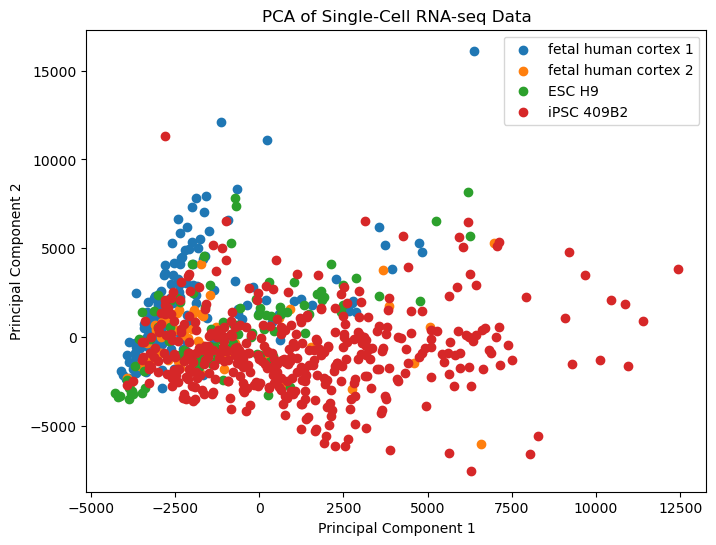

[0.10529254 0.07885465]


In [11]:
def pca_batches(expression_batches):
    
    '''
    '''
    # Perform PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(expression_batches.transpose())
    # Create a DataFrame with the PCA results
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'],
                          index = expression_batches.columns)
#     pca_df['Batch'] = expression_batches.columns

    # Plot the PCA results
    plt.figure(figsize=(8, 6))
    for batch in pca_df.index.unique():
        subset = pca_df[pca_df.index == batch]
        plt.scatter(subset['PC1'], subset['PC2'], label=batch)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Single-Cell RNA-seq Data')
    plt.legend()
    plt.show()
    print(pca.explained_variance_ratio_)

    return 

pca_batches(expression_batched)

Species    ['Homo sapiens']
cell_type1    ['dosal cortex progenitor' 'Unknown' 'dosal cortex neuron' 'neuron'
 'mesenchyme' 'ventral progenitor']
Source    ['Fetal neocortex'
 'Microdissected cortical-like ventricle from cerebral organoid'
 'Dissociated whole cerebral organoid']
age    ['12 weeks post-conception' '13 weeks post-conception' '53 days' '58 days'
 '35 days' '37 days' '41 days' '65 days' '33 days']
batch    ['fetal human cortex 1' 'fetal human cortex 2' 'ESC H9' 'iPSC 409B2']


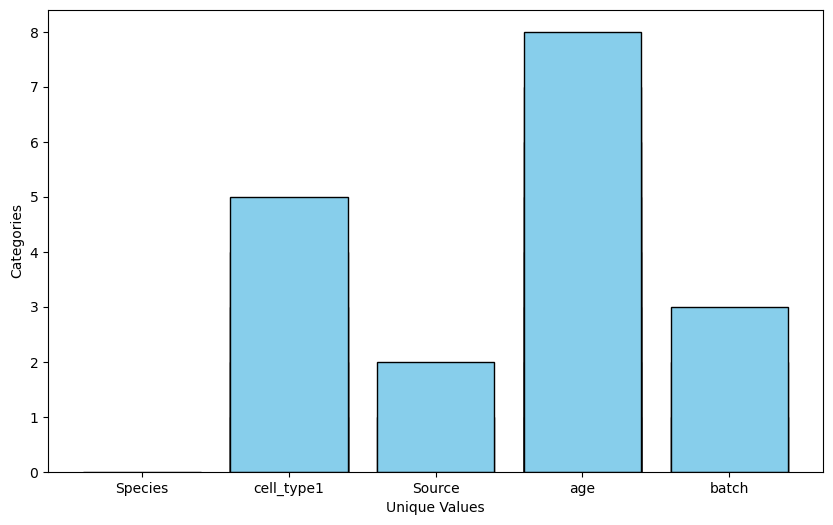

In [12]:
bar_plot = {}
for col in meta_data.columns:
  print(col + '   ', meta_data[col].unique())

  bar_plot[col]  = meta_data[col].unique()

# Plotting
plt.figure(figsize=(10, 6))

# For each key-value pair in the data, create a horizontal bar
for i, (key, values) in enumerate(bar_plot.items()):
    plt.bar([key]*len(values),range(len(values)), color="skyblue", edgecolor="black")

# Adding labels and title
plt.xlabel("Unique Values")
plt.ylabel("Categories")
plt.title("")
# plt.gca().invert_yaxis()  # Invert y-axis for better readability

# Show plot
plt.show()


# Preprocess Data

**Filter Out Low Quality Cells**
1. Low number of detected genes
2. Low count depth
3. High percentage of mitochondrial counts (dying cells with broken membranes)
4. Quality control is performed at the sample level as thresholds can vary substantially between samples.

**Filter Out Cells with Total log_reads < 16**

count       734.000000
mean     242772.974212
std       67357.469589
min       52215.441756
10%      168901.394288
15%      180252.396888
25%      199655.684762
50%      236101.406304
75%      281630.315542
max      473414.548435
dtype: float64


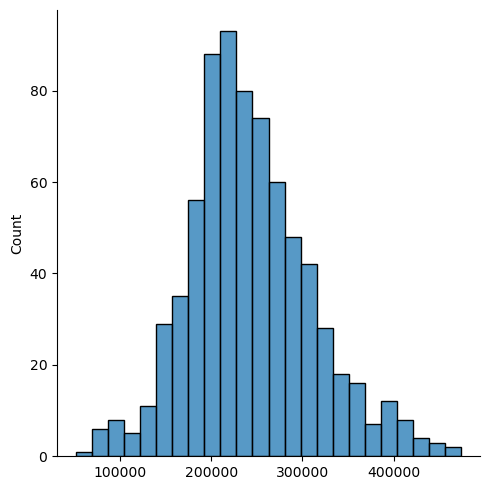

In [13]:
total_counts  = expression_data.sum(axis = 0)
print(total_counts.describe(percentiles = [0.10, 0.15, 0.25, 0.50, 0.75]))
sns.displot(total_counts)

count      734.000000
mean     15162.846049
std       1238.842663
min      11785.000000
25%      14224.750000
50%      15493.000000
75%      16100.250000
max      18074.000000
dtype: float64


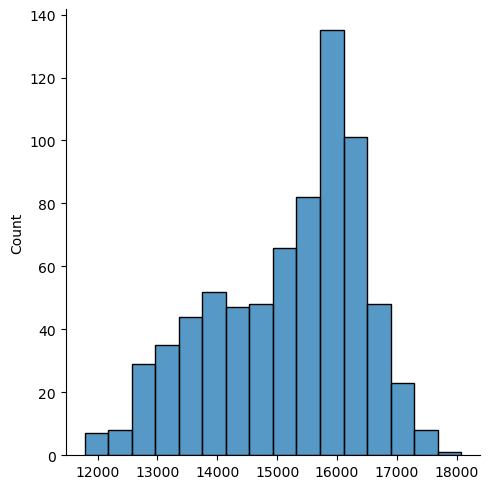

In [14]:
missing_genes = (expression_data == 0.0).sum(axis = 0)
print(missing_genes.describe())
sns.displot(missing_genes)

**Filter Out Cells with Low Number of Genes**
1. Total of 18900 genes in dataset
2. Filter out cells that are 2 std away from mean of genes (~17500 genes are missing or 1400 genes)
3. Filter out cells with less than 4000 counts

# Scanpy Workflow

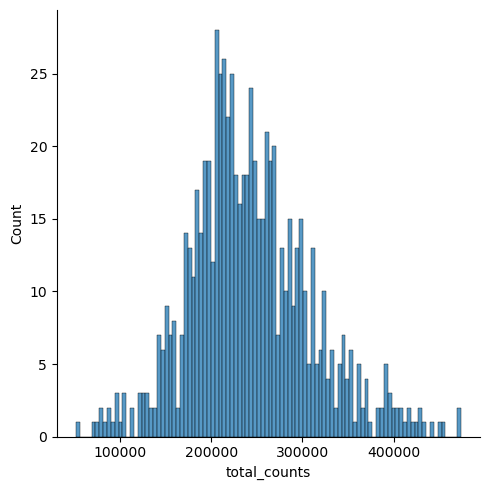

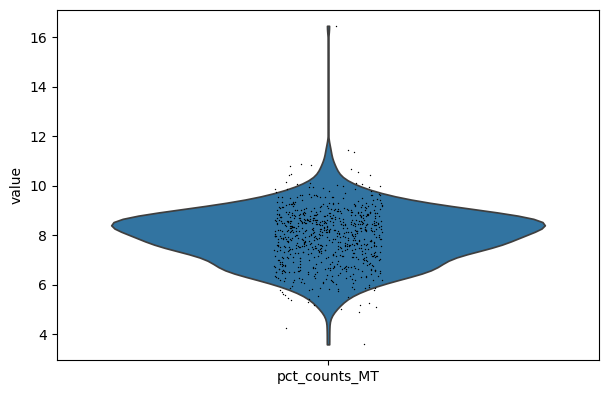

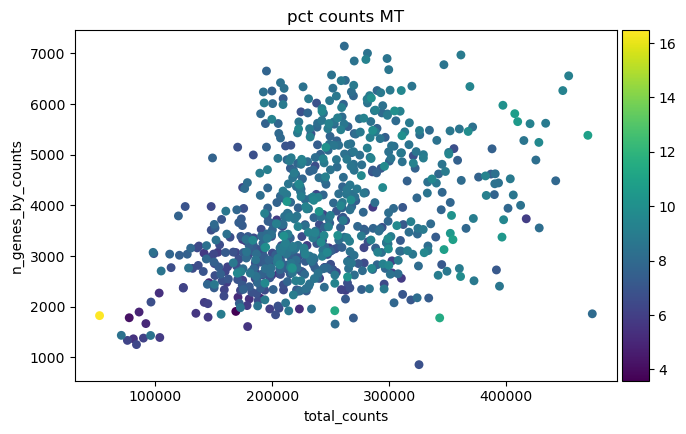

In [15]:
class ScanpyObject:

  # Data: Gene x Cell Row Matrix with Cells in index
  #       Columns Gene IDS correspond to the Columns

  # Leiden Groups: # of Groups for Clustering In Leiden Algorithm
  # Random State: The random seed introduced to Python for reproducability
  # PCA, UMAP, and TSNE utilitze a stochastic gradient algorithm (starting point matters)
  # PCA is determinsitic but due to the high rank of these datasets, "random PCA" may be used
  '''
  min_counts: The minimum counts needed for a cell to not be filtered out (low quality cells have low counts)
  '''
  # Metalables: Title of Column Describing Gene Categorization
  #             For example: mRNA, Protein coding, siRNA, etc.,

  def __init__(self,
               data,
               min_counts = None,
               leiden_groups = 15,
               random_state  = 42,
               percent_top   = 20, 
               metalabels    = 'protein_coding',
               log_data      = True,
               normalize     = True,
               plot_qc       = True,
               manual_filtering = False,
               target_sum    = 10000):

    self.log_data           = log_data
    self.data_object        = sc.AnnData(data.copy())
    self.data_highvar       = None
    self.leiden_gene_groups = leiden_groups   # TSNE Plots leiden groups
    self.random_state       = random_state    # Seed For Reproducability

    if normalize:
      sc.pp.normalize_total(self.data_object, target_sum = target_sum)

    if log_data:
      sc.pp.log1p(self.data_object)

    self._preprocess_workflow(metalabels, min_counts, percent_top, manual_filtering, plot_qc)
    
#     sc.pp.highly_variable_genes(self.data_object, min_mean=0.0125, max_mean=3, min_disp=0.5)

    # self._regress_highvar()
    # self._nearest_neighbors()
    # self._dimension_reduction()
    
    
  def is_outlier(self, adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


  def _preprocess_workflow(self, metalabels, min_counts, percent_top, manual_filtering, plot_qc):
    
    # Initialize Variables Avoid Errors
    total_counts   = None
    n_genes_counts = None
    
    self._mitochondrial()
    self._calculate_qc_metrics(percent_top)
    if plot_qc:
        self.plot_qc()
        
    if manual_filtering and min_counts is not None:
        self._filter_cells(min_counts)
    
    else:
  
        total_counts   = 'total_counts'
        n_genes_counts = 'n_genes_by_counts'

        self.data_object.obs['outlier'] = (
        self.is_outlier(self.data_object, total_counts, 5)
        | self.is_outlier(self.data_object, n_genes_counts, 5)
        | self.is_outlier(self.data_object, f'pct_counts_in_top_{percent_top}_genes', 5)
        )
        
        self.data_object.obs["MT_outlier"] = self.is_outlier(self.data_object, "pct_counts_MT", 3) | (
        self.data_object.obs["pct_counts_MT"] > 8
        )

        
  def plot_qc(self):
    
    p1 = sns.displot(self.data_object.obs['total_counts'], bins=100, kde=False)
    # sc.pl.violin(adata, 'total_counts')
    p2 = sc.pl.violin(self.data_object, f'pct_counts_MT')
    p3 = sc.pl.scatter(self.data_object, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT')
    
  def _mitochondrial(self, prefix = 'MT'):
    self.data_object.var[prefix] = self.data_object.var_names.str.startswith(prefix)
    
  def _filter_cells(self, min_counts):
    sc.pp.filter_cells(self.data_object, min_counts = min_counts)

  def _calculate_qc_metrics(self, percent_top):

    self.non_qc = ['highly_variable', 'means', 'dispersions', 'dispersions_norm']
    self.qc     = [col for col in self.data_object.var if col not in self.non_qc]
    
    sc.pp.calculate_qc_metrics(self.data_object, qc_vars=self.data_object.var[self.qc],
                                           percent_top=[percent_top], log1p=False, inplace=True)

  # Creates Another Object, With High Variability Genes Only
  def _regress_highvar(self):

    self.data_highvar  = self.data_object[:, self.data_object.var.highly_variable]
    sc.pp.regress_out(self.data_highvar, ['total_counts', 'pct_counts_Mt_rRNA'])

  # Leiden Clustering
  def _nearest_neighbors(self):
    sc.pp.neighbors(self.data_highvar, n_neighbors=10, n_pcs=40)
    sc.tl.leiden(self.data_highvar) # calculate the neighbors

  def _retreive_ranked_groups(self):
    gene_groups     = self.leiden_gene_groups
    gene_ranks_list = list(self.data_highvar.uns['rank_genes_groups']['names'])
    if len(gene_ranks_list) != 0:
      ranked_groups = gene_ranks_list[:gene_groups]

    return ranked_groups

  def _dimension_reduction(self):
    sc.pp.pca(self.data_highvar, svd_solver = 'arpack', random_state = self.random_state)
    sc.tl.pca(self.data_highvar, svd_solver = 'arpack')
    sc.tl.rank_genes_groups(self.data_highvar, 'leiden', method='t-test')


  # def _attach_metalabels(self, metalabels):
    # for metalabel in ids[metalabels].unique():
    #   self.data_object.var[metalabel] = self.data_object.var_names.str.startswith(metalabel)

  def leiden_ranking(self):
    sc.pl.rank_genes_groups(self.data_highvar, n_genes=self.leiden_gene_groups, sharey=False)

  def marker_genes(self):
    markers       = 2
    ranked_groups = self._retreive_ranked_groups()
    top_ranked    = {value: list(ranked_groups[value])[0:markers] for value in range(len(ranked_groups))}

    return top_ranked

  # -------------------------------------------------------------------------------------
  # Plot UMAP Takes The Highest Rank Marker Gene and Plots with UMAP
  # UMAP (Unifold Manifold) is a technique that aims to separate similar groups
  # UMAP is purely a visual technqiue, meaning the axes have no meaning
  # Separation does indicate that the groups are similar, but not as interpretable as PCA

  def plot_umap(self, color_type = 'highly_variable'):
    highly_variable = self.marker_genes()
    highly_variable = list(highly_variable.values())
    highly_variable = [gene[0] for gene in highly_variable]

    # # highly_variable = ['ENSG00000001561', 'ENSG00000286231']
    sc.tl.paga(self.data_highvar)
    sc.pl.paga(self.data_highvar, plot     =  False)  # remove `plot=False` if you want to see the coarse-grained graph
    sc.tl.umap(self.data_highvar, init_pos = 'paga')

    if color_type == 'highly_variable':
      sc.pl.umap(self.data_highvar, color=highly_variable)
    else:
      sc.pl.umap(self.data_highvar, color = color_type)

  def pca(self, gene_id = 'ENSG00000283761'):
    sc.pl.pca(self.data_highvar, color = gene_id, annotate_var_explained = True)

  def plot_high_expr(self):
    sc.pl.highest_expr_genes(self.data_object, n_top = 20)

  def plot_tsne(self):
    sc.tl.tsne(self.data_highvar, use_rep = 'X_pca')
    sc.pl.tsne(self.data_highvar, color=["leiden"], cmap="tab20")

  def scatter_plots(self):
    if not self.data_object.var.empty:
      total_plots = len(self.data_object.var.columns)
      fig, ax     = plt.subplots(8,5, figsize=(40,24))
      row         = 0
      col         = 0
      for plot in range(total_plots):
          protein_type = str(self.data_object.var.columns[plot])
          try:
            sc.pl.scatter(self.data_object, x='total_counts',
                          y = 'pct_counts_' + protein_type, ax = ax[row, col], show = False)
          # Deal with ax[row, col] calling for

          # Total Counts, n_genes_counts, etc
          except ValueError:
            col -= 1     # Counter Col += 1 Count


          col += 1
          if col > 4:
              row += 1
              col = 0
    else:
      raise ValueError(f'''{self.data_object.var} does not contain any data. Preprocess
      metalabels to receive scatter plots''')

  def plot_highly_variable(self):
    sc.pl.highly_variable_genes(self.data_object)

  def plot_pca_variance_ratio(self):
    sc.pl.pca_variance_ratio(self.data_highvar, log=True)


# Mitochondrial Genes Look Good
# Total count depth looks good for all genes
# Filtering with is_outlier function keeps all data
# Data may have been filtered already

min_counts  = expression_data.sum(axis = 1).describe()['min'] # 16^2 (256 counts) lots of cells have 0
scanpy_obj1 = ScanpyObject(expression_data.transpose(),
                           min_counts       = min_counts, 
                           log_data         = False, 
                           normalize        = False, 
                           percent_top      = 20,
                           manual_filtering = False)     # meta indexes data
# scanpy_obj2 = ScanpyObject(data_obj) # original indexes data

adata     = scanpy_obj1.data_object

In [16]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

# Only Errors from R will be Displayed
rcb.logger.setLevel(logging.ERROR)

# Allows for Dataframe Conversion from R and Pandas seamlessly
ro.pandas2ri.activate()

# Allows for Anndata conversion to R seamlesleslly
# anndata2ri.activate()

# Magic command to load the R jupyter notebooks extension with python
%load_ext rpy2.ipython
# %reload_ext rpy2.ipython

**`Add Necessary Permissions for R to write to R package location**

In [ ]:
# Download in terminal
# sudo apt-get update && sudo apt-get install libopenblas-dev

In [17]:
!sudo chmod -R 777 /usr/lib/R/site-library /usr/lib/R/library /usr/local/lib/R/site-library

^C


**If Error lock something something happens excute the following**
1. rm -rf /home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-Matrix


In [ ]:
%%R
cran <- "http://cran.us.r-project.org"
lib  <- '/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1'

# remotes::install_version('Matrix', version = '1.6-1.1', repos = cran)
# remotes::install_version('SeuratObject', version = '4.1.4', repos = cran, lib = lib)
# remotes::install_version("Seurat", version = "4.4.0", repos = cran, lib = lib)

* installing *source* package ‘Matrix’ ...
** package ‘Matrix’ successfully unpacked and MD5 sums checked
** using staged installation
** libs


gcc -I"/usr/share/R/include" -DNDEBUG -DNTIMER -I./SuiteSparse_config -DUSE_FC_LEN_T     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c CHMfactor.c -o CHMfactor.o
gcc -I"/usr/share/R/include" -DNDEBUG -DNTIMER -I./SuiteSparse_config -DUSE_FC_LEN_T     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c Csparse.c -o Csparse.o
gcc -I"/usr/share/R/include" -DNDEBUG -DNTIMER -I./SuiteSparse_config -DUSE_FC_LEN_T     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c init.c -o init.o
gcc -I"/usr/share/R/include" -DNDEBUG -DNTIMER -I./SuiteSparse_config -DUSE_FC_LEN_T     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protec

ar: `u' modifier ignored since `D' is the default (see `U')


gcc -I"/usr/share/R/include" -DNDEBUG -I../Include -I../../SuiteSparse_config     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -I../Include -DDLONG -c colamd.c -o colamd_l.o
ar -rucs ../../COLAMD.a colamd.o colamd_l.o
make[2]: Leaving directory '/tmp/Rtmp2SQ8kK/remotes1b878a970f9/Matrix/src/COLAMD/Source'
make[1]: Leaving directory '/tmp/Rtmp2SQ8kK/remotes1b878a970f9/Matrix/src/COLAMD'
make[1]: Entering directory '/tmp/Rtmp2SQ8kK/remotes1b878a970f9/Matrix/src/AMD'
( cd Source ; make -f "/usr/lib/R/etc/Makeconf" -f Makefile lib )
make[2]: Entering directory '/tmp/Rtmp2SQ8kK/remotes1b878a970f9/Matrix/src/AMD/Source'
gcc -I"/usr/share/R/include" -DNDEBUG -I../Include -I../../SuiteSparse_config     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -I../Include -DDI

ar: `u' modifier ignored since `D' is the default (see `U')


gcc -I"/usr/share/R/include" -DNDEBUG -I../Include -I../../SuiteSparse_config     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -I../Include -DDLONG -c amd_1.c -o amd_l_1.o
gcc -I"/usr/share/R/include" -DNDEBUG -I../Include -I../../SuiteSparse_config     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -I../Include -DDINT -c amd_2.c -o amd_i_2.o
gcc -I"/usr/share/R/include" -DNDEBUG -I../Include -I../../SuiteSparse_config     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -I../Include -DDLONG -c amd_2.c -o amd_l_2.o
gcc -I"/usr/share/R/include" -DNDEBUG -I../Include -I../../SuiteSparse_config     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg

ar: `u' modifier ignored since `D' is the default (see `U')
ar: `u' modifier ignored since `D' is the default (see `U')
installing to /home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-Matrix/00new/Matrix/libs
** R
** data
** inst
** byte-compile and prepare package for lazy loading


Creating a generic function for ‘zapsmall’ from package ‘base’ in package ‘Matrix’
Creating a generic function for ‘unname’ from package ‘base’ in package ‘Matrix’
Creating a generic function for ‘drop’ from package ‘base’ in package ‘Matrix’
in method for ‘coerce’ with signature ‘"matrix.csc","dgCMatrix"’: no definition for class “matrix.csc”
in method for ‘coerce’ with signature ‘"matrix.csr","dgRMatrix"’: no definition for class “matrix.csr”
in method for ‘coerce’ with signature ‘"matrix.coo","dgTMatrix"’: no definition for class “matrix.coo”
in method for ‘coerce’ with signature ‘"matrix.csr","dgCMatrix"’: no definition for class “matrix.csr”
in method for ‘coerce’ with signature ‘"matrix.coo","dgCMatrix"’: no definition for class “matrix.coo”
in method for ‘coerce’ with signature ‘"matrix.csc","CsparseMatrix"’: no definition for class “matrix.csc”
in method for ‘coerce’ with signature ‘"matrix.csc","RsparseMatrix"’: no definition for class “matrix.csc”
in method for ‘coerce’ with 

** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (Matrix)
* installing *source* package ‘SeuratObject’ ...
** package ‘SeuratObject’ successfully unpacked and MD5 sums checked
** using staged installation
** libs


g++ -std=gnu++14 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c RcppExports.cpp -o RcppExports.o


In file included from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Core:205,
                 from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Dense:1,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigenForward.h:28,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigen.h:25,
                 from RcppExports.cpp:4:
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/in

g++ -std=gnu++14 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c data_manipulation.cpp -o data_manipulation.o


In file included from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Core:205,
                 from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Dense:1,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigenForward.h:28,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigen.h:25,
                 from data_manipulation.cpp:1:
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/usr/local/lib/R/site-library/RcppEi

gcc -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c valid_pointer.c -o valid_pointer.o
g++ -std=gnu++14 -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o SeuratObject.so RcppExports.o data_manipulation.o valid_pointer.o -L/usr/lib/R/lib -lR


installing to /home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-SeuratObject/00new/SeuratObject/libs
** R
** data
*** moving datasets to lazyload DB
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (SeuratObject)


These packages have more recent versions available.
It is recommended to update all of them.
Which would you like to update?

1: All                                   
2: CRAN packages only                    
3: None                                  
4: caTools      (1.18.2 -> 1.18.3) [CRAN]
5: reticulate   (1.38.0 -> 1.39.0) [CRAN]
6: SeuratObject (4.1.4  -> 5.0.2 ) [CRAN]
7: ggrepel      (0.9.5  -> 0.9.6 ) [CRAN]



* installing *source* package ‘Seurat’ ...
** package ‘Seurat’ successfully unpacked and MD5 sums checked
** using staged installation
** libs


g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include' -I'/usr/local/lib/R/site-library/RcppProgress/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c ModularityOptimizer.cpp -o ModularityOptimizer.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include' -I'/usr/local/lib/R/site-library/RcppProgress/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c RModularityOptimizer.cpp -o RModularityOptimizer.o


In file included from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Core:205,
                 from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Dense:1,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigenForward.h:28,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigen.h:25,
                 from RModularityOptimizer.cpp:9:
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/usr/local/lib/R/site-library/Rcp

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include' -I'/usr/local/lib/R/site-library/RcppProgress/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c RcppExports.cpp -o RcppExports.o


In file included from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Core:205,
                 from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Dense:1,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigenForward.h:28,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigen.h:25,
                 from RcppExports.cpp:4:
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/in

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include' -I'/usr/local/lib/R/site-library/RcppProgress/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c data_manipulation.cpp -o data_manipulation.o


In file included from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Core:205,
                 from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Dense:1,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigenForward.h:28,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigen.h:25,
                 from data_manipulation.cpp:1:
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/usr/local/lib/R/site-library/RcppEi

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include' -I'/usr/local/lib/R/site-library/RcppProgress/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c fast_NN_dist.cpp -o fast_NN_dist.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include' -I'/usr/local/lib/R/site-library/RcppProgress/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c integration.cpp -o integration.o


In file included from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Core:205,
                 from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Dense:1,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigenForward.h:28,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigen.h:25,
                 from integration.cpp:1:
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/in

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include' -I'/usr/local/lib/R/site-library/RcppProgress/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c snn.cpp -o snn.o


In file included from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Core:205,
                 from /usr/local/lib/R/site-library/RcppEigen/include/Eigen/Dense:1,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigenForward.h:28,
                 from /usr/local/lib/R/site-library/RcppEigen/include/RcppEigen.h:25,
                 from snn.cpp:1:
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/usr/local/lib/R/site-library/RcppEigen/include/Ei

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include' -I'/usr/local/lib/R/site-library/RcppProgress/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c stats.cpp -o stats.o
gcc -I"/usr/share/R/include" -DNDEBUG  -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppEigen/include' -I'/usr/local/lib/R/site-library/RcppProgress/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c valid_pointer.c -o valid_pointer.o
g++ -std=gnu++17 -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o Seurat.so ModularityOptimizer.o RModularityOptimizer.o RcppExports.o data_manipulation

installing to /home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-Seurat/00new/Seurat/libs
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (Seurat)


Installing package into ‘/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [19]:
%%R 
# install.packages('SoupX')
# library(SoupX)

* installing *source* package ‘SoupX’ ...
** package ‘SoupX’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (SoupX)


Installing package into ‘/home/sagemaker-user/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/SoupX_1.6.2.tar.gz'
Content type 'application/x-gzip' length 4962415 bytes (4.7 MB)
downloaded 4.7 MB


The downloaded source packages are in
	‘/tmp/Rtmp2SQ8kK/downloaded_packages’


**Use Update command if this fails**

In [18]:
%%R
library(SingleCellExperiment)
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)
library(SoupX)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, ro

# Actual R Workflow 
---

In [21]:
data_matrix = scanpy_obj1.data_object.X.T

**Identify Doublets in the dataset**

In [22]:
%%R -i data_matrix -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_matrix),
    ) 
)

doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 4 cells excluded from training.
iter=1, 12 cells excluded from training.
iter=2, 13 cells excluded from training.
Threshold found:0.907
12 (1.6%) doublets called


In [50]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

scDblFinder_class
singlet    722
doublet     12
Name: count, dtype: int64

**Chapter 7: Gene Normalization Techniques**

In [23]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    # color_map="YlGnBu",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

/tmp/ipykernel_629/1495493670.py:11: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [24]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

**Normalize Total Counts and log the data**

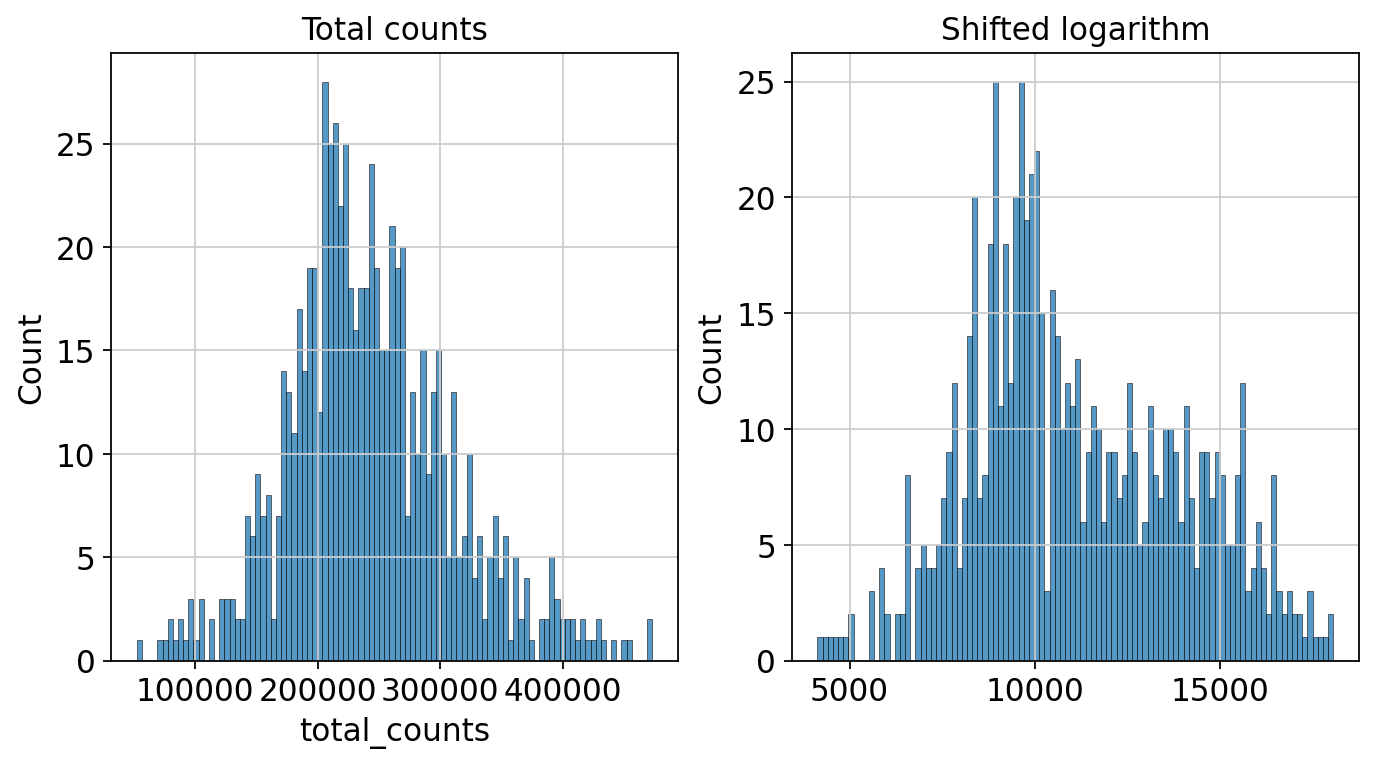

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [26]:
from scipy.sparse import csr_matrix, issparse

In [27]:
%%R
library(scran)
library(BiocParallel)

**SCRAN normalization with Size Factors**

In [28]:
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

2024-09-09 00:11:52.307378: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_629/2253560473.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_pp, key_added="groups")


In [29]:
data_mat = adata_pp.X.T
# convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70

# Convert to sparse
if issparse(data_mat):
    # Less than 32bits
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()


ro.globalenv["data_mat"]        = data_mat
ro.globalenv["input_groups"]    = adata_pp.obs["groups"]

In [30]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM  = MulticoreParam()
    )
)

In [31]:
adata.obs['Size Factors'] = size_factors
scran_normalized = adata.X / adata.obs['Size Factors'].values[:, None]
adata.layers["scran_normalization"]     = csr_matrix(sc.pp.log1p(scran_normalized))

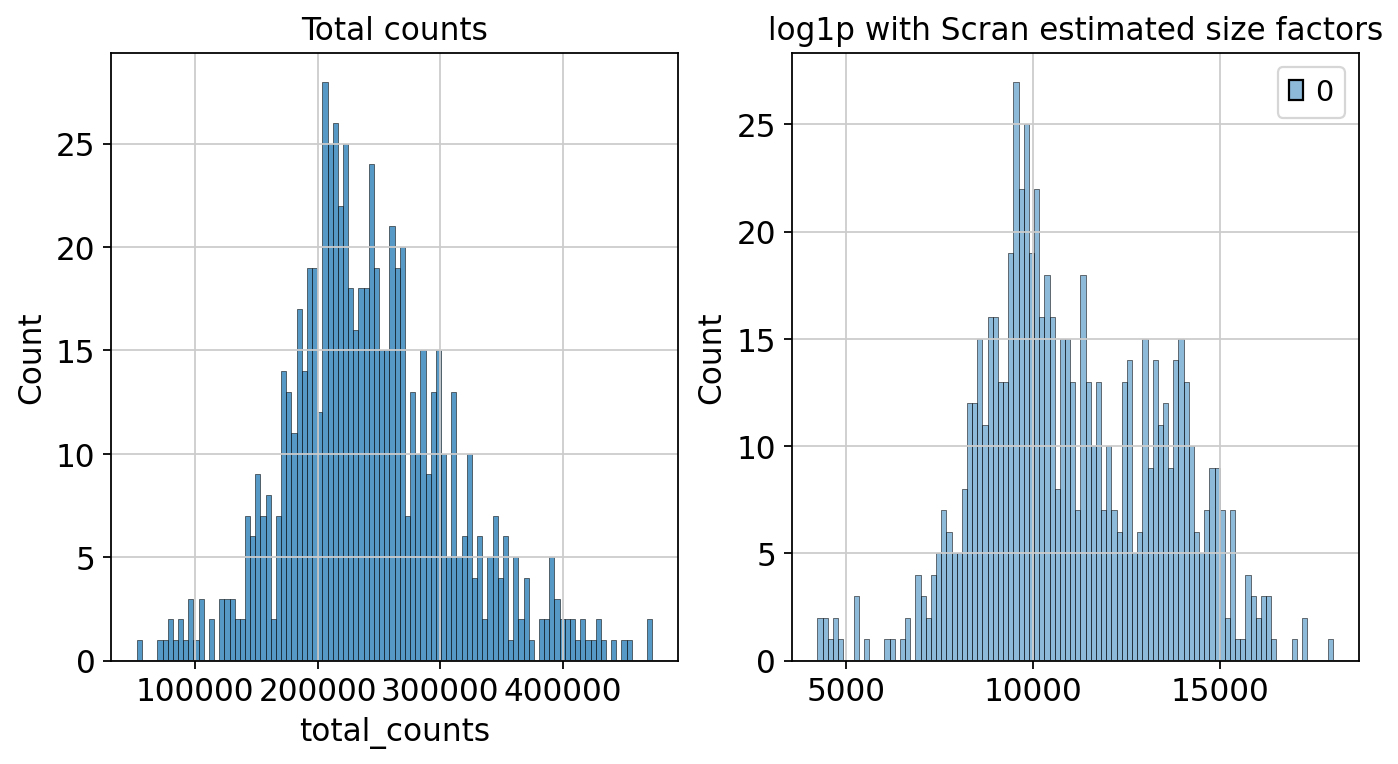

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("log1p with Scran estimated size factors")
plt.show()

**Analyitc Pearson Residuals**

In [33]:
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

/opt/conda/lib/python3.10/site-packages/scanpy/experimental/pp/_normalization.py:54: UserWarning: `normalize_pearson_residuals()` expects raw count data, but non-integers were found.
  warn(


/opt/conda/lib/python3.10/site-packages/scanpy/experimental/pp/_normalization.py:70: RuntimeWarning: invalid value encountered in divide
  residuals = diff / np.sqrt(mu + mu**2 / theta)


Text(0.5, 1.0, 'Analytic Pearson residuals')

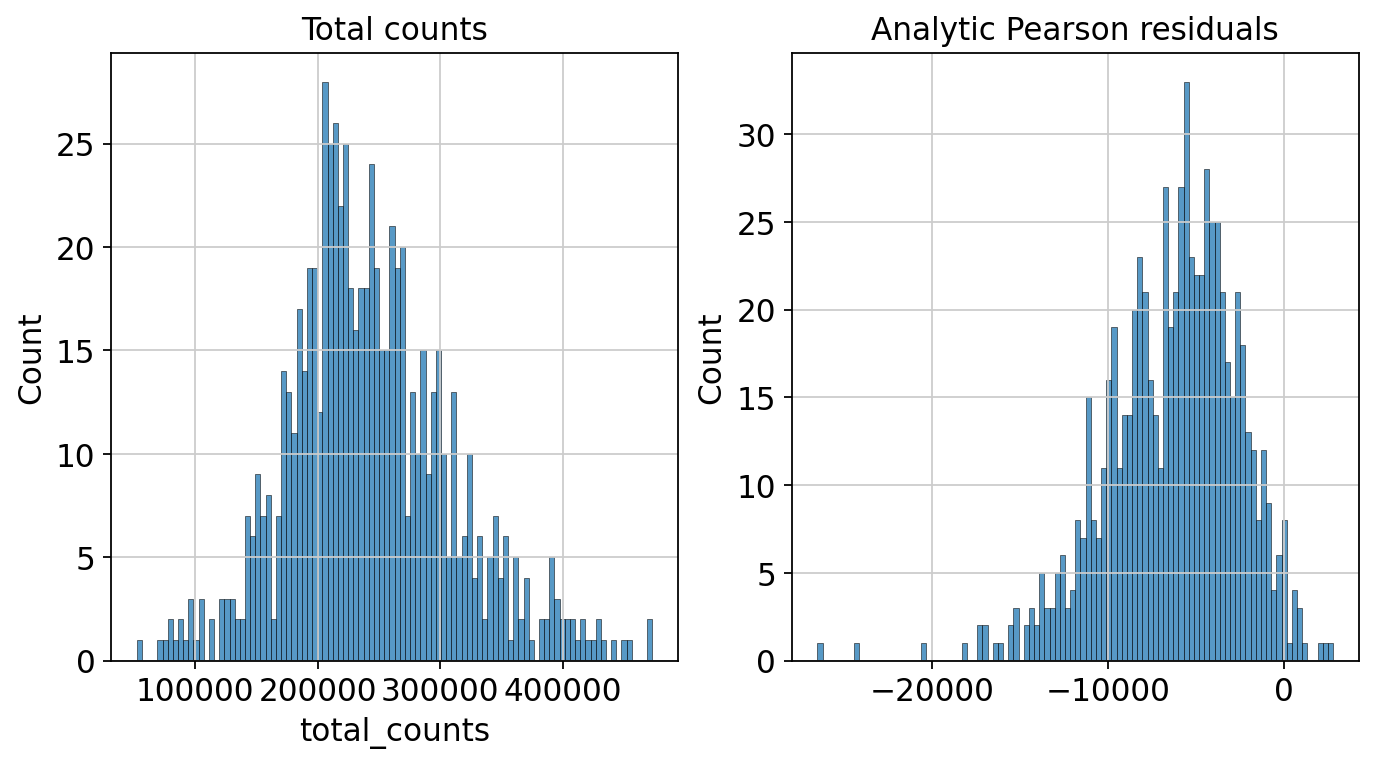

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
pearson_residuals = pd.DataFrame(adata.layers["analytic_pearson_residuals"].todense()).sum(axis = 1)
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    pearson_residuals, bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("Analytic Pearson residuals")

In [35]:
ro.globalenv["adata"] = adata

In [36]:
%%R
# BiocManager::install('scry')
library(scry)


In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
2: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
3: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
4: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [37]:
%%R
sce = devianceFeatureSelection(adata, assay="X")

In [38]:
binomial_deviance = ro.r("rowData(sce)$binomial_deviance").T

In [39]:
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

adata.var["highly_deviant"]    = mask
adata.var["binomial_deviance"] = binomial_deviance

In [40]:
sc.pp.highly_variable_genes(adata, layer="scran_normalization")

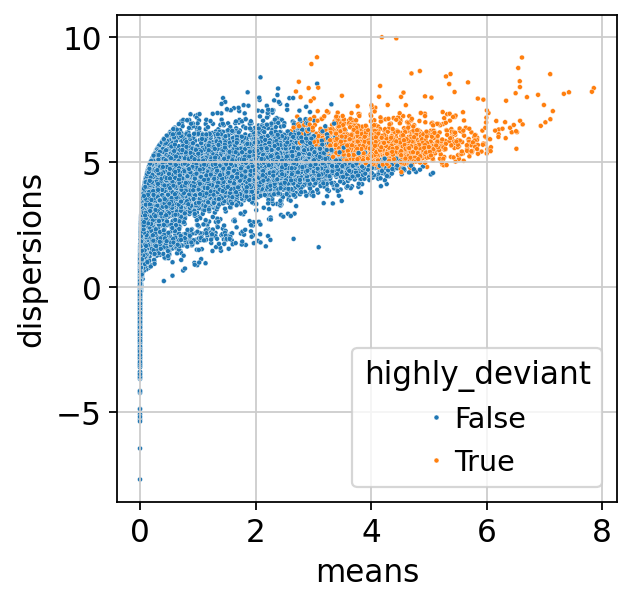

In [41]:
ax = sns.scatterplot(
    data=adata.var, x="means", y="dispersions", hue="highly_deviant", s=5
)

plt.show()

**Section 9: Dimensionality Reduction**

In [52]:
adata_copy = adata.copy()
adata_copy.X = adata.layers['log1p_norm']

In [53]:
# setting highly variable as highly deviant to use scanpy 'use_highly_variable' argument in sc.pp.pca
adata_copy.var["highly_variable"] = adata_copy.var["highly_deviant"]
sc.pp.pca(adata_copy, svd_solver="arpack", use_highly_variable=True)

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


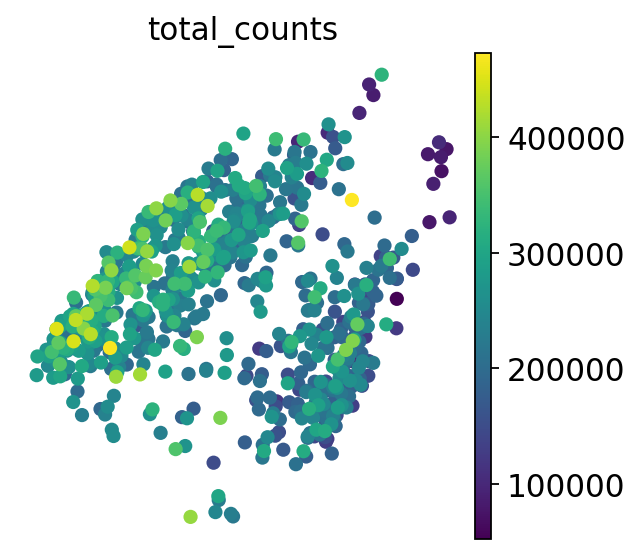

In [44]:
sc.pl.pca_scatter(adata_copy, color="total_counts")

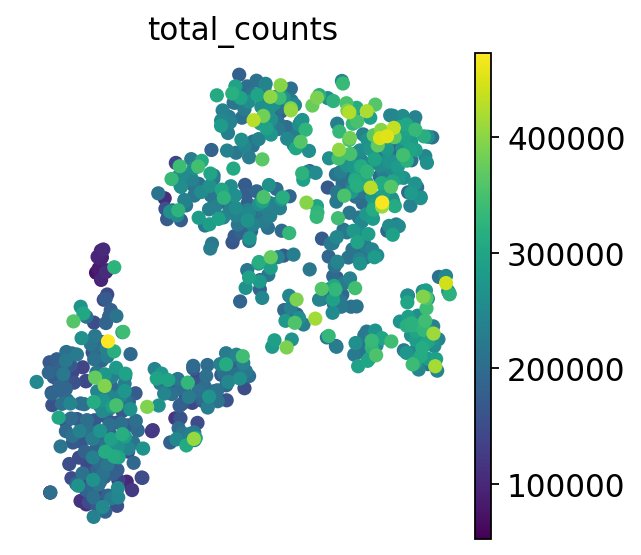

In [54]:
sc.tl.tsne(adata_copy, use_rep="X_pca")
sc.pl.tsne(adata_copy, color="total_counts")

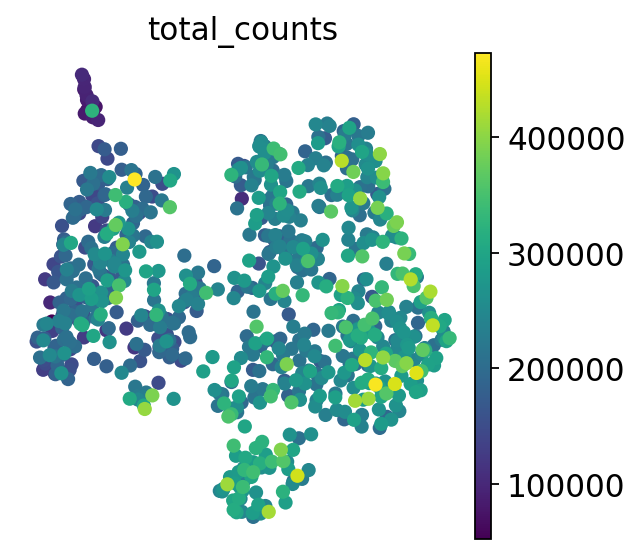

In [55]:
sc.pp.neighbors(adata_copy)
sc.tl.umap(adata_copy)
sc.pl.umap(adata_copy, color="total_counts")

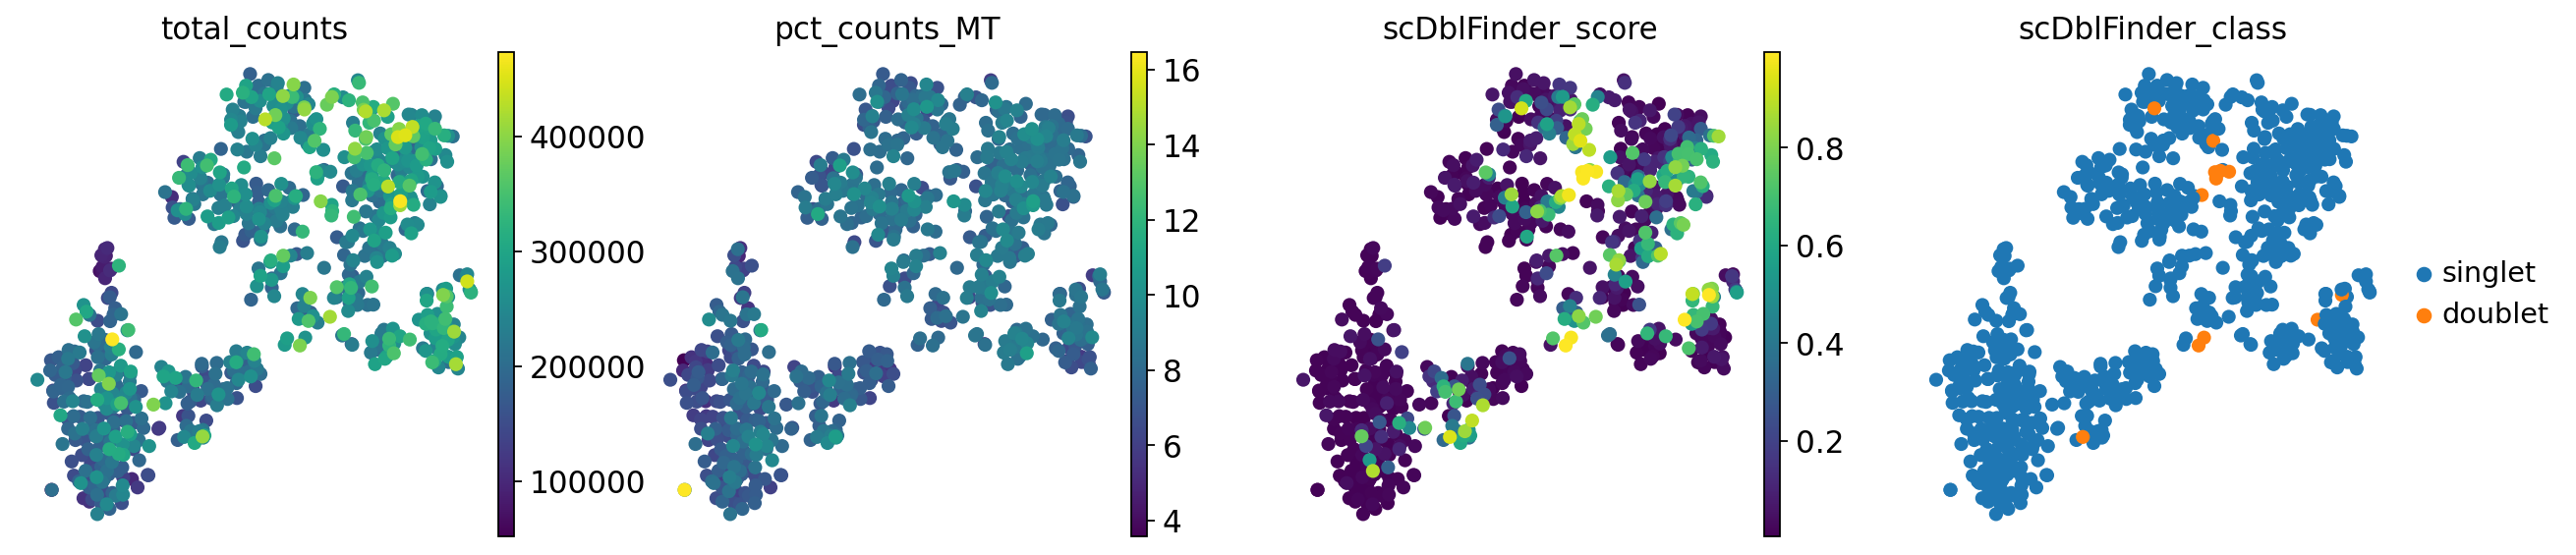

In [56]:
sc.pl.tsne(
    adata_copy,
    color=["total_counts", "pct_counts_MT", "scDblFinder_score", "scDblFinder_class"],
)

In [57]:
sc.pp.neighbors(adata_copy, n_pcs=30)
sc.tl.umap(adata_copy)

res1 = 0.25
res2 = 0.50
res3 = 1.00

sc.tl.leiden(adata_copy, key_added = f'leiden_res_{res1}', resolution = res1)
sc.tl.leiden(adata_copy, key_added = f'leiden_res_{res2}', resolution = res2)
sc.tl.leiden(adata_copy, key_added = f'leiden_res_{res3}', resolution = res3)

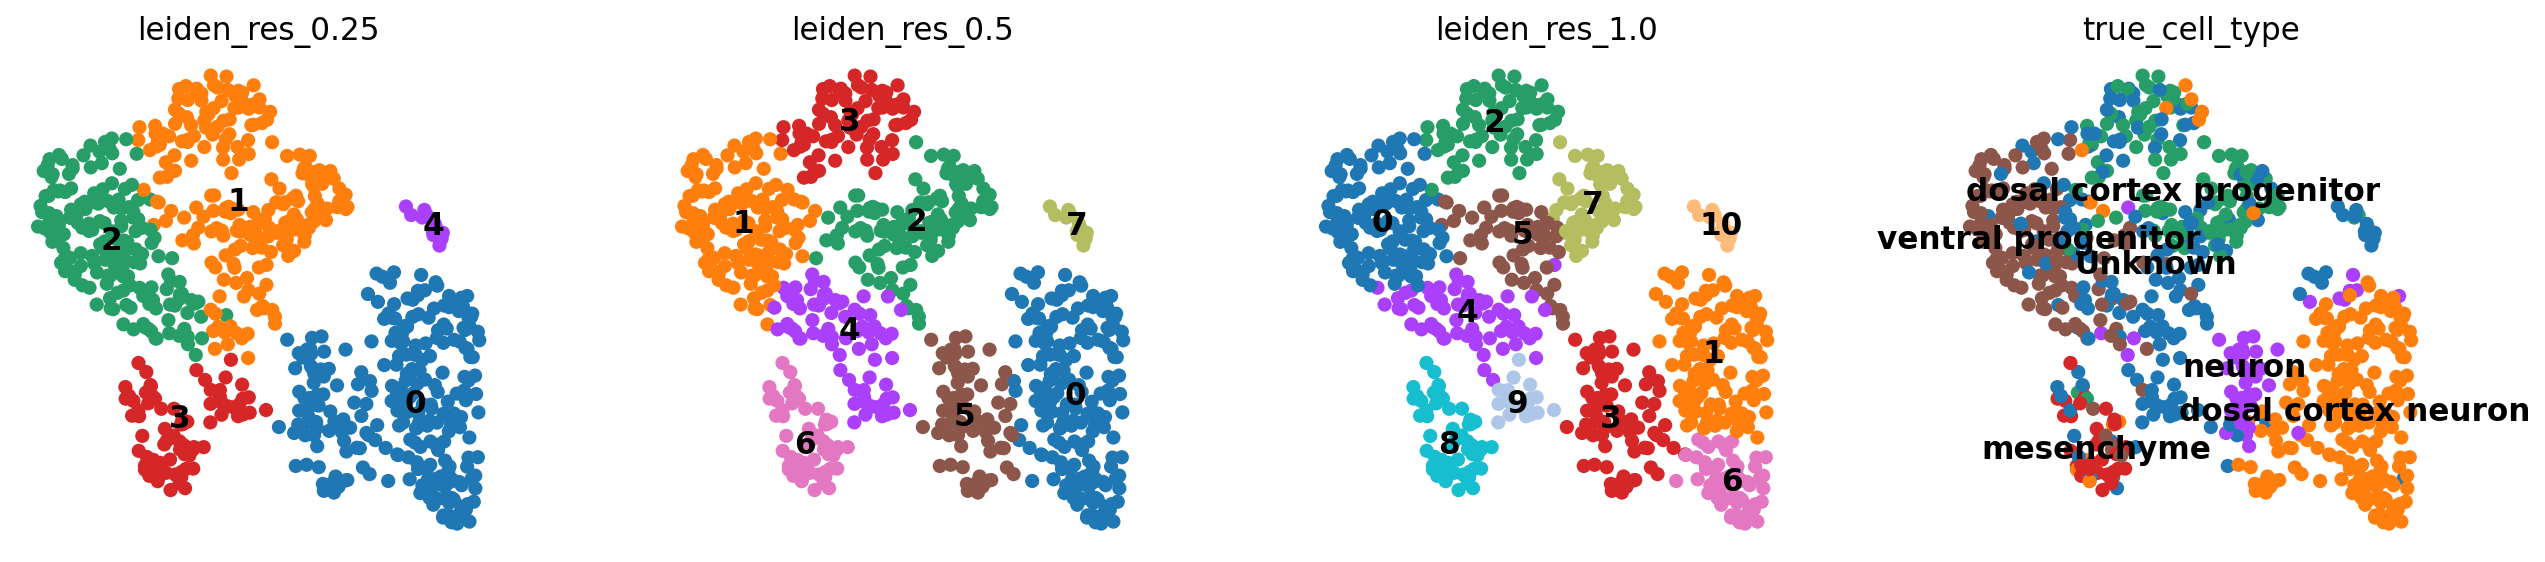

In [65]:
adata_copy.obs['true_cell_type'] = meta_data['cell_type1']
sc.pl.umap(
    adata_copy,
    color=[f"leiden_res_{res1}", f"leiden_res_{res2}", f"leiden_res_{res3}"],
    legend_loc="on data",
)

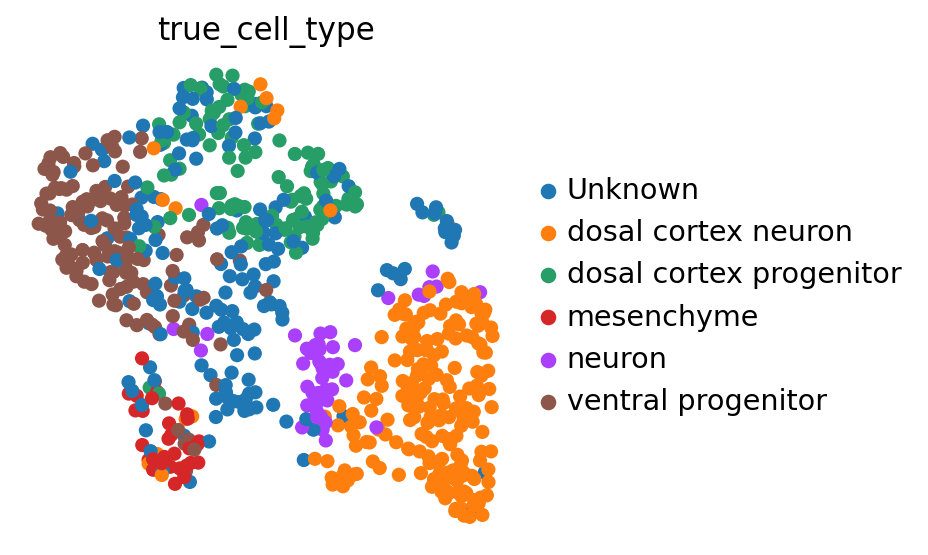

In [67]:
sc.pl.umap(
    adata_copy,
    color=['true_cell_type'],
    # legend_loc="on data",
)

**Cell Typist Annotations**

In [68]:
!pip install celltypist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 13.1 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 27.1 MB/s eta 0:00:00


In [72]:
import celltypist

celltypist.models.models_description()

,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_COVID19_PBMC.pkl,peripheral blood mononuclear cell types from C...
3,Adult_CynomolgusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult cynom...
4,Adult_Human_MTG.pkl,cell types and subtypes (10x-based) from the a...
5,Adult_Human_PancreaticIslet.pkl,cell types from pancreatic islets of healthy a...
6,Adult_Human_PrefrontalCortex.pkl,cell types and subtypes from the adult human d...
7,Adult_Human_Skin.pkl,cell types from human healthy adult skin
8,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...
9,Adult_Mouse_OlfactoryBulb.pkl,cell types from the olfactory bulb of adult mice


In [107]:
adata_celltypist = adata.copy()  # make a copy of our adata
adata_celltypist.X = adata.to_df().values # set adata.X to raw counts
sc.pp.normalize_per_cell(
    adata_celltypist, counts_per_cell_after=10**4
)  # normalize to 10,000 counts per cell (required by celltypist)
sc.pp.log1p(adata_celltypist)  # log-transform
# make .X dense instead of sparse, for compatibility with celltypist:
adata_celltypist.X = adata_celltypist.X

In [82]:
prefrontal_model = celltypist.models.Model.load('Adult_Human_PrefrontalCortex.pkl')  # Replace with the appropriate brain-related model('Adult_Human_PrefrontalCortex.pkl')
dev_brain_model  = celltypist.models.Model.load('Developing_Human_Brain.pkl')        # Replace with the appropriate brain-related model('Developing_Human_Brain.pkl')


In [120]:
prefrontal_predictions = celltypist.annotate(adata_celltypist, 
                                model=prefrontal_model,
                                majority_voting = True)

In [121]:
brain_predictions = celltypist.annotate(adata_celltypist, 
                                model=dev_brain_model,
                                majority_voting = True)

In [122]:
prefrontal_predictions.predicted_labels['predicted_labels'].value_counts()

predicted_labels
Endo CLDN5 SLC7A5        511
Oligo MOG OPALIN         130
Micro P2RY12 APBB1IP      36
L2-3 CUX2 NTNG1 PALMD     30
PC P2RY14 GRM8             8
L6 OPRK1 SMYD1 KCND2       5
SMC ACTA2 CRISPLD2         4
InN SST HTR2C              2
InN SST NPY                2
Endo CLDN5 IL1R1           1
InN LAMP5 RELN             1
InN PVALB PIEZO2           1
SMC ACTA2 CNN1             1
SMC ACTA2 CYP1B1           1
VLMC COL1A2 VLMCA8         1
Name: count, dtype: int64

In [123]:
brain_predictions.predicted_labels['predicted_labels'].value_counts()

predicted_labels
Diencephalon radial glia        91
Telencephalon radial glia       66
Forebrain neuron                56
Brain fibroblasts               49
Cortex radial glia              47
Forebrain glioblast             47
Cortex neuron                   46
Ventral midbrain neuron         44
Midbrain radial glia            41
Forebrain radial glia           37
Forebrain neuroblast            36
Cortex neuroblast               17
Cortex neuronal IPC             17
Striatum radial glia            15
Thalamus radial glia            13
Ventral midbrain radial glia    12
Forebrain neuronal IPC          10
Medulla neuroblast               8
Striatum neuroblast              7
Pons radial glia                 6
Hypothalamus radial glia         6
Telencephalon neuron             6
Dorsal midbrain radial glia      5
Striatum neuron                  5
Medulla radial glia              5
Medulla glioblast                4
Midbrain neuroblast              4
Cerebellum radial glia           3
Bra

In [134]:
brain_adata = brain_predictions.to_adata()

adata_copy.obs["celltypist_cell_label"] = brain_adata.obs.loc[
    adata_copy.obs.index, "majority_voting"
]
adata_copy.obs["celltypist_conf_score"] = brain_adata.obs.loc[
    adata_copy.obs.index, "conf_score"
]

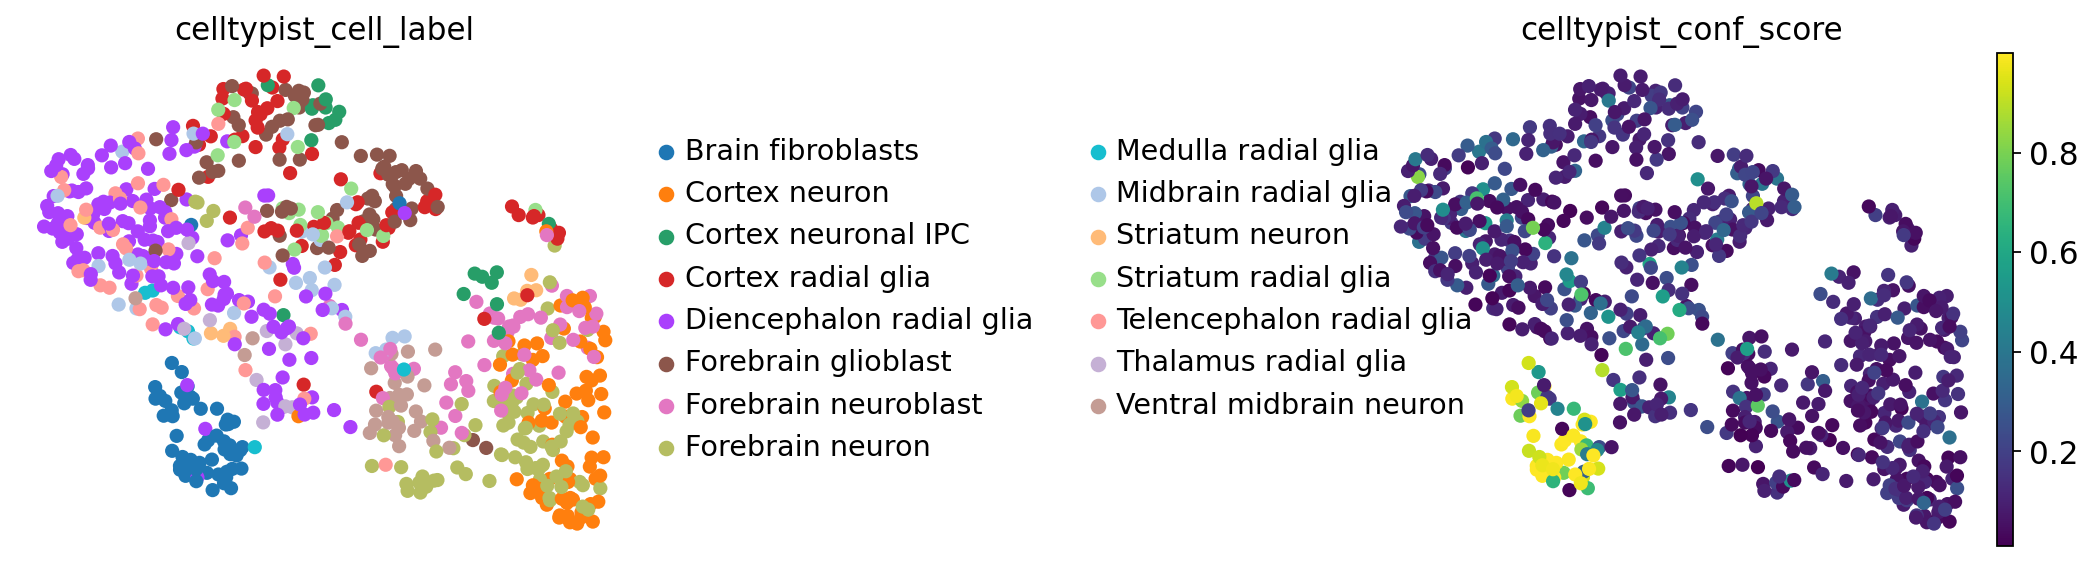

In [135]:
sc.pl.umap(
    adata_copy,
    color=["celltypist_cell_label", "celltypist_conf_score"],
    frameon=False,
    sort_order=False,
    wspace=1,
)